<a href="https://colab.research.google.com/github/apapaioannou92/BA/blob/HW3/aap2204_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IEOR 4650  Business Analytics (Fall 2019)**

**Homework 3 [Total points: 60]**

** Due: 11:59 PM, October 16 **

This second homework consists of Python programming practices and the applications to Poisson regression. 

The steps to finish in the homework:

*   Step 1: Make a copy of the file to your LionDrive.
*   Step 2: Work with the copy (an ipynb file).
*    <font color='red'>**Step 3: Rename the copy to your_uni_hw3.ipynb (For example: yd4501_hw3.ipynb).**</font>  
*   Step 4: Submit the copy on CourseWorks.

Before you submit your assignment, make sure to re-run your code from the beginning. (You can do so by first clicking Runtime/Reset All Runtimes and then clicking Runtime/Run all)


**All the questions in this homework requires coding**

In [0]:
#This imports all the packages you need for the homework
#Please run this first


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#import modules

import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import sklearn 
import scipy.special as spsp
from scipy.optimize import minimize
import scipy.stats as spst

#Exercise 1 [Total: 23 points]


##Setting
In this example, we take a closer look at the data we used for Poisson regression. 

This data measures the number of ad exposures each customer got **within 1 day**. 


(1) In the class, we checked the model fitting based on how closely the predicted numbers of customers having different number of exposures match with the samples we actually observe. In this exercise, we will explore how to apply cross-validation to Poisson regression.

(2) We are interested in using this dataset to make meaningful business recommendation.

In [146]:
#Load the dataset
link="https://drive.google.com/open?id=1pjdoOKuczV8Zc6Zw8-yUh6q2tqogN-xt"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Exposure.csv')  
Ad = pd.read_csv('Exposure.csv')
Ad.head(5)



,Cookie_ID,Exposures
0,1,0
1,2,0
2,3,3
3,4,49
4,5,4


## Q1 [10 points]

**[Cross validation]**

In the class, we checked the model fitting based on how closely the predicted numbers of customers having different number of exposures match with the samples we actually observe. However, we were basically doing the model selection and model fitting using the chunk of data. 

For this exercise, let's first separate the data by

* first randomize the data 
* Split our data into 3 sets. 

>> Training: The first 4000 observations

>> Validation: Observation 4001 to 4500

>> Testing: Observation 4501 to 5000.

We then test which model is the best model.

* Simple Poisson
* 2-segment Poisson 
* Zero-inflated Poisson 
* NBD (Poisson-Gamma)

For the model accuracy, let's use the joint log likelihood. Again, the higher the joint log likelihood, the better the model is. 

Based on the result, rank the model performance from the highest to the lowest.





In [0]:
#don't remove this line (otherwise, you lose 2 points)
np.random.seed(30)

#shuffle and split
from sklearn.utils import shuffle
Ad = shuffle(Ad)

# Splitting the dataset to training, validation and testing
# Training set
Ad_training = Ad[0:4000]
# Validation set
Ad_validation = Ad[4001:4500]
# Testing set
Ad_testing = Ad[4501:5000]

In [148]:
#Model1
Exposures_m1=Ad_training["Exposures"].values

def neg_LL_m1(beta):
  lmbda_m1=np.exp(beta)
  #individual log likelihood
  ind_LL_m1=np.log(spst.poisson.pmf(Exposures_m1,lmbda_m1))
  #joint log likelihood
  Joint_LL_m1=np.sum(ind_LL_m1)
  return -Joint_LL_m1

#randomly select a starting point
guess_m1=np.random.rand()
#start minimization
result_m1=minimize(neg_LL_m1,guess_m1,method="BFGS")
lmbda_estimate_m1=np.exp(result_m1.x)
print('For λ_hat =', lmbda_estimate_m1, ', the value of the joint log likelihood is: ', -neg_LL_m1(result_m1.x) )

# from statsmodels.formula.api import poisson
# #define the poisson model 
# model_m1= poisson("Exposures~1",data=Exposures_m1).fit()
# print(model_m1.summary())
# #recover lambda_hat_m1
# lambda_hat_m1=np.exp(model_m1.params[0]) 
# lambda_hat_m1

For λ_hat = [2.50574998] , the value of the joint log likelihood is:  -15598.20007108814


In [149]:
#Model2
Exposures_m2=Ad_training["Exposures"].values

def neg_LL_m2(betas):

  lmbda1_m2=np.exp(betas[0])
  lmbda2_m2=np.exp(betas[1])
  p_m2=np.exp(betas[2])/(1+np.exp(betas[2]))
  #individual likelihood
  Likelihood1_m2=spst.poisson.pmf(Exposures_m2,lmbda1_m2)
  Likelihood2_m2=spst.poisson.pmf(Exposures_m2,lmbda2_m2)
  ind_L_m2=Likelihood1_m2*p_m2+Likelihood2_m2*(1-p_m2)

  #individual log likelihood
  ind_LL_m2=np.log(ind_L_m2)
  #joint log likelihood
  return  -np.sum(ind_LL_m2)

guess_m2=np.random.rand(3)
result_m2=minimize(neg_LL_m2,guess_m2,method="BFGS")
betas_m2=result_m2.x
lmbda1_h_m2=np.exp(betas_m2[0])
lmbda2_h_m2=np.exp(betas_m2[1])
p_h_m2=np.exp(betas_m2[2])/(1+np.exp(betas_m2[2]))
# print(lmbda1_h_m2,lmbda2_h_m2,p_h_m2)
print('For λ1_hat =', lmbda1_h_m2, 'and λ2_hat =', lmbda2_h_m2, ', the value of the joint log likelihood is: ', -neg_LL_m2([betas_m2[0],betas_m2[1],p_h_m2]) )


For λ1_hat = 0.5787409435021467 and λ2_hat = 10.365841748699301 , the value of the joint log likelihood is:  -8664.505046587676


In [150]:
#Model3
Exposures_m3=Ad_training["Exposures"].values

def neg_LL_m3(betas):

  lmbda1_m3=0
  lmbda2_m3=np.exp(betas[0])
  p_m3=np.exp(betas[1])/(1+np.exp(betas[1]))
  #individual likelihood
  Likelihood1_m3=spst.poisson.pmf(Exposures_m3,lmbda1_m3)
  Likelihood2_m3=spst.poisson.pmf(Exposures_m3,lmbda2_m3)
  ind_L_m3=Likelihood1_m3*p_m3+Likelihood2_m3*(1-p_m3)

  #individual log likelihood
  ind_LL_m3=np.log(ind_L_m3)
  #joint log likelihood
  return  -np.sum(ind_LL_m3)

guess_m3=np.random.rand(2)
result_m3=minimize(neg_LL_m3,guess_m3,method="BFGS")
betas_m3=result_m3.x
lmbda1_h_m3=0
lmbda2_h_m3=np.exp(betas_m3[0])
p_h_m3=np.exp(betas_m3[1])/(1+np.exp(betas_m3[1]))
#joing log likelihood
print(-result_m3.fun)
# print(lmbda1_h_m3,lmbda2_h_m3,p_h_m3)

print('For λ1_hat =', lmbda1_h_m3, 'and λ2_hat =', lmbda2_h_m3, ', the value of the joint log likelihood is: ', -neg_LL_m3([betas_m3[0], betas_m3[1], p_h_m3]) )

-10311.585140918709
For λ1_hat = 0 and λ2_hat = 5.562404720520923 , the value of the joint log likelihood is:  -10311.585140918709


In [151]:
#Model4
Exposures_m4=Ad_training["Exposures"].values

def neg_LL_m4(betas):
  #compute alpha, gamma
  alpha_m4=np.exp(betas[0])
  gamma_m4=np.exp(betas[1])
  #individual  likelihood
  ind_L_m4=spsp.gamma(gamma_m4+Exposures_m4)/spsp.gamma(gamma_m4)/spsp.gamma(Exposures_m4+1)\
  *(1/(1+alpha_m4))**Exposures_m4*(alpha_m4/(1+alpha_m4))**gamma_m4
  #individual log likelihoo
  ind_LL_m4=np.log(ind_L_m4)
  #joint log likelihood
  Joint_LL_m4=np.sum(ind_LL_m4)
  return -Joint_LL_m4

guess_m4=np.random.rand(2)
betas_m4=minimize(neg_LL_m4,guess_m4,method="BFGS").x

#recover alpha, gamma
alpha_m4=np.exp(betas_m4[0])
gamma_m4=np.exp(betas_m4[1])

# print(alpha_m4,gamma_m4)

print('For α =', alpha_m4, 'and γ =', gamma_m4, ', the value of the joint log likelihood is: ', -neg_LL_m4([betas_m4[0],betas_m4[1]]) )

For α = 0.09964502397861887 and γ = 0.2496855187594558 , the value of the joint log likelihood is:  -7387.770799599681


In [152]:
print('The best model is the NBD model, since it has the highest joint log likelihood. The second best model is the 2-segment Poisson model, since it has the') 
print('2nd highest joint log likelihood, and then the Zero-inflated Poisson, and the Simple Poisson model follow.')

The best model is the NBD model, since it has the highest joint log likelihood. The second best model is the 2-segment Poisson model, since it has the
2nd highest joint log likelihood, and then the Zero-inflated Poisson, and the Simple Poisson model follow.


##Q2 [4 points]

Based on the model learned on the training set, report the expected number of exposures for the market using each model you tested in Q1.

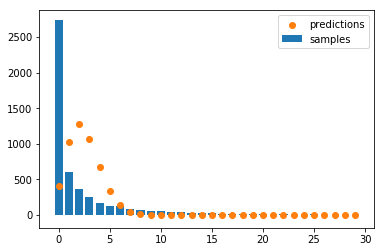

In [153]:
# Model 1
mkt_size = len(Ad)
Tally_m1=Ad.groupby(["Exposures"]).count()
Tally_m1
Exposures_m1_index = Tally_m1.index.values
Counts_m1 = Tally_m1.iloc[:,0].values
Predicted_Exposures_m1 = np.arange(0, np.max(Exposures_m1_index)+1)
Predicted_counts_m1 = spst.poisson.pmf(Predicted_Exposures_m1,lmbda_estimate_m1)*mkt_size
plt.bar(Exposures_m1_index[Exposures_m1_index<30], Counts_m1[Exposures_m1_index<30],label="samples")
plt.scatter(Predicted_Exposures_m1[Predicted_Exposures_m1<30], Predicted_counts_m1[Predicted_Exposures_m1<30],zorder=2,label="predictions")
plt.legend(loc="best")
plt.show()

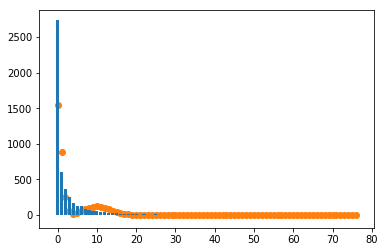

In [154]:
# Model 2
Exposures_m2=Ad["Exposures"].values
mkt_size = len(Ad)
x_m2=np.arange(0, np.max(Exposures_m2+1))
pmf_m2 = spst.poisson.pmf(x_m2,lmbda1_h_m2)*p_h_m3+spst.poisson.pmf(x_m2,lmbda2_h_m2)*(1-p_h_m2)
prediction_m2 = mkt_size*pmf_m2

Tally_m2 = Ad.groupby(["Exposures"]).count()
plt.bar(Tally_m2.index.values,Tally_m2.iloc[:,0].values)
plt.scatter(x_m2,prediction_m2)

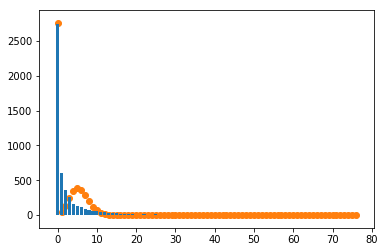

In [155]:
# Model 3
Exposures_m3=Ad["Exposures"].values
mkt_size = len(Ad)
x_m3 = np.arange(0, np.max(Exposures_m3+1))
pmf_m3 = spst.poisson.pmf(x_m3 ,lmbda1_h_m3)*p_h_m3+spst.poisson.pmf(x_m3,lmbda2_h_m3)*(1-p_h_m3)
prediction_m3 = mkt_size*pmf_m3
Tally_m3 = Ad.groupby(["Exposures"]).count()
plt.bar(Tally_m3.index.values,Tally_m3.iloc[:,0].values)
plt.scatter(x_m3,prediction_m3)

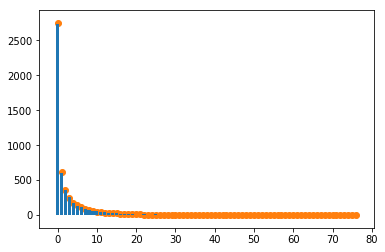

In [156]:
# Model 4
Exposures_m4 = Ad["Exposures"].values
mkt_size = len(Ad)
x_m4 = np.arange(0, np.max(Exposures_m4+1))
PMF_m4 = spsp.gamma(gamma_m4+x_m4)/spsp.gamma(gamma_m4)/spsp.gamma(x_m4+1)*(1/(1+alpha_m4))**x_m4*(alpha_m4/(1+alpha_m4))**gamma_m4
prediction_m4 =  PMF_m4*mkt_size
Tally_m4 = Ad.groupby(["Exposures"]).count()
plt.bar(Tally_m4.index.values,Tally_m4.iloc[:,0].values)
plt.scatter(x_m4,prediction_m4)

In [157]:
# Model 1
mrkt_size = len(Ad)

print('The expected number of exposures for the market using model 1, ie Simple Poisson model, equals to E[X]*mrkt_size=λ*mrkt_size=', lmbda_estimate_m1*mrkt_size)

# Model 2

print('The expected number of exposures for the market using model 2, ie 2-segment Poisson model, equals to E[X]*mrkt_size=(Likelihood1_m2*p_h_m2+Likelihood2_m2*(1-p_h_m2)*mrkt_size)=', (lmbda1_h_m2*p_h_m2+lmbda2_h_m2*(1-p_h_m2))*mrkt_size)

# Model 3

print('The expected number of exposures for the market using model 3, ie zero-inflated Poisson model, equals to E[X]*mrkt_size=((1-p)*λ)*mrkt_size=', ((1-p_h_m3)*lmbda2_h_m3)*mrkt_size)

# Model 4

print('The expected number of exposures for the market using model 4, ie NBD model, equals to E[X]*mrkt_size=(γ/α)*mrkt_size=', (gamma_m4/alpha_m4)*mrkt_size)

The expected number of exposures for the market using model 1, ie Simple Poisson model, equals to E[X]*mrkt_size=λ*mrkt_size= [12528.74990112]
The expected number of exposures for the market using model 2, ie 2-segment Poisson model, equals to E[X]*mrkt_size=(Likelihood1_m2*p_h_m2+Likelihood2_m2*(1-p_h_m2)*mrkt_size)= 12528.750826112015
The expected number of exposures for the market using model 3, ie zero-inflated Poisson model, equals to E[X]*mrkt_size=((1-p)*λ)*mrkt_size= 12528.749695156934
The expected number of exposures for the market using model 4, ie NBD model, equals to E[X]*mrkt_size=(γ/α)*mrkt_size= 12528.749996238226


## Q3 [9 points]

Assume that we decide to stick to NBD model, we want to use this model to do something meaningful.

(1) Based on the model, how many people do you predict on the testing set to have at most 1 exposure? How does this number match with the actual observation?

(2) How many more days of exposures do we at least need to reduce this number to below 200? [You only need to consider integer days]

(3) Assume a customer had 0 exposures, visualize the posterior distribution of $\lambda$ for this customer.

(4) Assume a customer had 5 exposures, visualize the posterior distribution of $\lambda$ for this customer.



In [158]:
# (1)
Exposures_m4 = Ad_testing["Exposures"].values
mkt_size = len(Ad_testing)
x_m4_new = np.arange(0, np.max(Exposures_m4+1))
PMF_m4_new =spsp.gamma(gamma_m4+x_m4_new)/spsp.gamma(gamma_m4)/spsp.gamma(x_m4_new+1)*(1/(1+alpha_m4))**x_m4_new*(alpha_m4/(1+alpha_m4))**gamma_m4
prediction_m4_new =  PMF_m4_new*mkt_size
No_of_people_ = np.sum(prediction_m4_new[0:2])
print('Predicted: ', No_of_people_, 'vs Actual: ', len(Ad_testing[Ad_testing['Exposures']<=1]))

Predicted:  336.19797941371667 vs Actual:  327


In [159]:
# (2)
Exposures_m4 = Ad_testing["Exposures"].values
mkt_size = len(Ad_testing)
#x UNITS of time
for i in range(1,500):  
  x_m4_new = np.arange(0, np.max(Exposures_m4+1))
  PMF_m4_new = spsp.gamma(gamma_m4+x_m4_new)/spsp.gamma(gamma_m4)/spsp.gamma(x_m4_new+1)*(i/(i+alpha_m4))**x_m4_new*(alpha_m4/(i+alpha_m4))**gamma_m4
  prediction_m4_new =  PMF_m4_new * mkt_size
  No_of_people_ = np.sum(prediction_m4_new[0:2])
  if No_of_people_<= 200:
    print('We need to reduce the number of days by: ', i, 'in order to get Expected No of people with at most 1 exposure =', No_of_people_)
    break

No_of_additional_exposures = 200*(alpha_m4+1)-gamma_m4
No_of_additional_exposures # or less

We need to reduce the number of days by:  10 in order to get Expected No of people with at most 1 exposure = 196.4321242025762


219.6793192769643

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


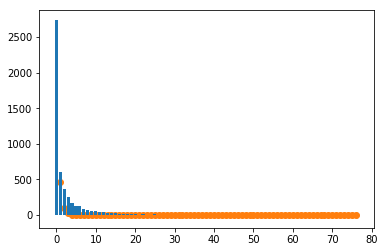

In [160]:
# (3)
Exposures_m4_all = Ad["Exposures"].values

# Expected posterior exposures
NBD_POST=(gamma_m4+Exposures_m4_all)/(alpha_m4+1)
Ad=Ad.assign(NBD_POST=NBD_POST)
Ad
Exposures_m4_all = Ad["Exposures"].values
mkt_size = len(Ad)
x_ = np.arange(0, np.max(Exposures_m4_all+1))
PMF_ = ( ( (alpha_m4+1)**(gamma_m4+0) )/spsp.gamma(gamma_m4+0) ) * x_**(gamma_m4+0-1) * np.exp( -(alpha_m4+1)* x_ )
prediction_ =  PMF_ * mkt_size
Tally_ = Ad.groupby(["Exposures"]).count()
plt.bar(Tally_.index.values,Tally_.iloc[:,0].values)
plt.scatter(x_,prediction_)

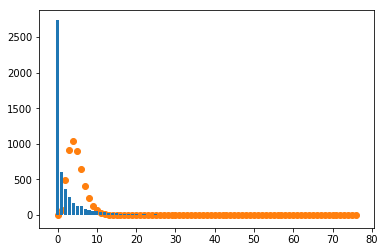

In [161]:
# (4)
Exposures_m4_all = Ad["Exposures"].values

# Expected posterior exposures
NBD_POST=(gamma_m4+Exposures_m4_all)/(alpha_m4+1)
Ad=Ad.assign(NBD_POST=NBD_POST)
Ad
Exposures_m4_all = Ad["Exposures"].values
mkt_size = len(Ad)
x_ = np.arange(0, np.max(Exposures_m4_all+1))
PMF_ = ( ( (alpha_m4+1)**(gamma_m4+5) )/spsp.gamma(gamma_m4+5) ) * x_**(gamma_m4+5-1) * np.exp( -(alpha_m4+1)* x_ )
prediction_ =  PMF_ * mkt_size
Tally_ = Ad.groupby(["Exposures"]).count()
plt.bar(Tally_.index.values,Tally_.iloc[:,0].values)
plt.scatter(x_,prediction_)

#Exercise 2 [Total: 37  Points]

##Setting

In this exercise, we discuss a model that deals with discrete timing. We will use sports analytics as the background for this study. The data is collected from Kaggle. [link](https://www.kaggle.com/kendallgillies/nflstatistics)

In this dataset, we have the information of all the NFL players who are both currently active and have already retired before 2018. In this question, we are interested in modeling the number of years they were active before they retire. 


In [162]:
#Load the dataset
link="https://drive.google.com/open?id=1voxCbS9xGieGHiEYYCzK61f4BZQWy6SD"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('NFL.csv')  
NFL = pd.read_csv('NFL.csv')
NFL.head(5)

,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Years Played
0,NaN,"Grand Rapids , MI",5/23/1921,Notre Dame,Retired,NaN,3 Seasons,71.0,NaN,NaN,"Evans, Fred",NaN,fredevans/2513736,NaN,185.0,1946 - 1948
1,NaN,"Dayton , OH",12/21/1930,Dayton,Retired,NaN,1 Season,70.0,NaN,NaN,"Raiff, Jim",NaN,jimraiff/2523700,NaN,235.0,1954 - 1954
2,56.0,"Temple , TX",9/11/1960,Louisiana Tech,Retired,NaN,1 Season,74.0,NaN,NaN,"Fowler, Bobby",NaN,bobbyfowler/2514295,NaN,230.0,1985 - 1985
3,30.0,"New Orleans , LA",9/30/1986,LSU,Retired,NaN,5 Seasons,73.0,NaN,NaN,"Johnson, Quinn",NaN,quinnjohnson/79593,NaN,255.0,2009 - 2013
4,25.0,"Detroit , MI",3/31/1992,Central Michigan,Active,Pittsburgh Steelers,3rd season,77.0,Clintondale HS,"Clinton Twp.,Macomb Co., MI","Walton, L.T.",96.0,l.t.walton/2552444,DE,305.0,NaN


##Q1 [3 points]
**[Data cleaning]**

We will clean our data using the following steps:
* **Keep only retired players**  
*  Based on the last column, Creat an array that gives the number of active years for each player. For example, if "Year Played" for a player is 1954-1954, the number of active years will be 0, while if  "Year Played" for a player is 1971 to 1974, the number of active years will be 3. You will find  [str.split()](https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/) function useful for this question.

In [174]:
# Keeping only the retired players

NFL_retired = NFL[NFL['Current Status']=='Retired']
# NFL_retired['Current Status'].value_counts()

# Dropping null value columns to avoid errors 
NFL_retired.dropna(subset=['Years Played'], inplace = True) 

# Creating a new data frame with split value columns 
new = NFL_retired["Years Played"].str.split("-", expand = True) 
  
# Making separate "Beginning Year" column from new data frame 
NFL_retired["Beginning Year"]= new[0].astype(int)
  
# Making separate "Ending Year" column from new data frame 
NFL_retired["Ending Year"] = new[1].astype(int)
  
# Dropping old "Years Played" columns 
NFL_retired.drop(columns =["Years Played"], inplace = True) 
  
# Displaying the df named NFL_retired
NFL_retired.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import

,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Beginning Year,Ending Year
0,NaN,"Grand Rapids , MI",5/23/1921,Notre Dame,Retired,NaN,3 Seasons,71.0,NaN,NaN,"Evans, Fred",NaN,fredevans/2513736,NaN,185.0,1946,1948
1,NaN,"Dayton , OH",12/21/1930,Dayton,Retired,NaN,1 Season,70.0,NaN,NaN,"Raiff, Jim",NaN,jimraiff/2523700,NaN,235.0,1954,1954
2,56.0,"Temple , TX",9/11/1960,Louisiana Tech,Retired,NaN,1 Season,74.0,NaN,NaN,"Fowler, Bobby",NaN,bobbyfowler/2514295,NaN,230.0,1985,1985
3,30.0,"New Orleans , LA",9/30/1986,LSU,Retired,NaN,5 Seasons,73.0,NaN,NaN,"Johnson, Quinn",NaN,quinnjohnson/79593,NaN,255.0,2009,2013
5,NaN,"Sumner , IL",9/11/1892,Illinois,Retired,NaN,1 Season,73.0,NaN,NaN,"Petty, Ross",NaN,rosspetty/2523136,NaN,180.0,1920,1920


In [175]:
NFL_retired["Number of Active Years"] = NFL_retired["Ending Year"] - NFL_retired["Beginning Year"]

# df named NFL_retired display 
NFL_retired.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Beginning Year,Ending Year,Number of Active Years
0,NaN,"Grand Rapids , MI",5/23/1921,Notre Dame,Retired,NaN,3 Seasons,71.0,NaN,NaN,"Evans, Fred",NaN,fredevans/2513736,NaN,185.0,1946,1948,2
1,NaN,"Dayton , OH",12/21/1930,Dayton,Retired,NaN,1 Season,70.0,NaN,NaN,"Raiff, Jim",NaN,jimraiff/2523700,NaN,235.0,1954,1954,0
2,56.0,"Temple , TX",9/11/1960,Louisiana Tech,Retired,NaN,1 Season,74.0,NaN,NaN,"Fowler, Bobby",NaN,bobbyfowler/2514295,NaN,230.0,1985,1985,0
3,30.0,"New Orleans , LA",9/30/1986,LSU,Retired,NaN,5 Seasons,73.0,NaN,NaN,"Johnson, Quinn",NaN,quinnjohnson/79593,NaN,255.0,2009,2013,4
5,NaN,"Sumner , IL",9/11/1892,Illinois,Retired,NaN,1 Season,73.0,NaN,NaN,"Petty, Ross",NaN,rosspetty/2523136,NaN,180.0,1920,1920,0


##Q2 [10 points]

**[Application of One-segment model]**

Let's think about what distribution would fit this variable. One assumption we can make is that for each year, there is a probability $\theta$ for this person to retire, probability $1-\theta$ for this person to remain active. We also assume that the years are independent from one another. We are interested in examining the number of years $y$ it takes for retirement to happen. This is modeled by a [Geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution), which is defined as the distribution that measures the number of failures ($y$) it takes before the first success happens when each trial are indepedently and identically distributed with probability of suceess equals $\theta$.

For a Geometric model, 

$P(y)=(1-\theta)^y \theta$ for  $y=0, 1, 2, ...$,

here $0< \theta< 1$.

$E(y)=\frac{1-\theta}{\theta}$

* Estimate $\hat{\theta}$ for this model  
* What is the expected number of years for a NFL player to be active?
* What is the probability for a player to serve for 4 years?
* Now do a visualization to check the model performance. In this graph

>> Visualize the observed number of players served 0 years, 1 years... using a bar chart 

>> Based on the model, predict the number of players served 0 years, 1 years, ... Visualize in the same graph as well using a scatter plot. 

0.31688428863677376


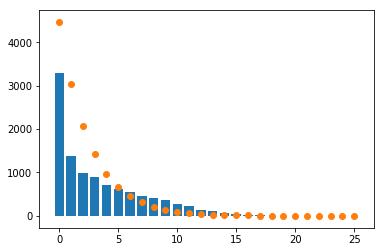

In [179]:
NFL_retired_ = NFL_retired['Number of Active Years'].values

def neg_LL(betas):
  #compute alpha, gamma
  theta = np.exp(betas[0])/( 1 + np.exp(betas[0]) )
  #individual  likelihood
  ind_L = ( (1-theta)**NFL_retired_) * theta
  #individual log likelihoo
  ind_LL=np.log(ind_L)
  #joint log likelihood
  Joint_LL=np.sum(ind_LL)
  return -Joint_LL

guess=np.random.rand(2)
betas=minimize(neg_LL,guess,method="BFGS").x

#recover alpha, gamma
theta=np.exp(betas[0])

print(theta)
size_ = len(NFL_retired)
x = np.arange(0, np.max(NFL_retired_+1))
PMF = ( (1-theta)**x) * theta
prediction=  PMF * size_
Tally=NFL_retired.groupby(['Number of Active Years']).count()
plt.bar(Tally.index.values,Tally.iloc[:,0].values, zorder=0)
plt.scatter(x,prediction)

##Q3 [10 points]
###[Estimating a two-segment model]

The previous model assumes that all the players have the same $\theta$, which might be a flawed assumption. Instead, we might want to model two segment of players: one segment players have high risk of retiring (high $\theta$), while the other segment of players have lower risk of retiring (low $\theta$)

* Use a two-segment model to identify $\theta_1$, $\theta_2$, and $p$
* Give an interpretation of these three estimated parameters in the context of this question.
* For each segment, what is the expected number of years for a player to remain active?
* If a player retired after 3 years of playing, what is the probability for this player to belong to the low risk group?
* Plot the observed v.s. predicted numbers like you did in Q1. Comment on any changes in the model fitting.
 

##Q4 [4 points]
**[Beta Prior]**

Now, we move on to assume that $\theta$ follows a continuous distribution. Again, we would like to make a choice of the distribution we want to use. It is often assumed that $\theta$ follows a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with $\theta \sim Beta(\alpha, \beta)$, which has the following pdf:

$f(\theta)=\frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha,\beta)}= \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}}$

Here, you can either use spsp.gamma to compute three parts of $B(\alpha,\beta)$ seperately. You can also simply use spsp.beta(alpha,beta) to compute $B(\alpha,\beta)$ directly.

where $\alpha$ and $\beta$ are both positive, $0<\theta<1$. In addition, $E(\theta)=\frac{\alpha}{\alpha+\beta}$

* Reproduce the following lineplot that shows the probability density functions for different $\alpha$ and $\beta$ values.  [The color of the lines does not matter]

You might find [this link](https://pythonforundergradengineers.com/unicode-characters-in-python.html)  useful.
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/650px-Beta_distribution_pdf.svg.png
" width="450"/>
</div>
[Source: Wikipedia]



##Q5 [6 points]
**[Geometric-Beta distribution]**

It can be derived that the probability of $y$ of a geometric distribution with a Beta prior (assuming $\theta \sim Beta(\alpha, \beta)$) will give the following PMF.

$P(y)=\frac{B(\alpha+1,y+\beta)}{B(\alpha,\beta)}$

* Estimate $\alpha$ and $\beta$ for this Geometric-Beta distribution.
* What is the probability for a player to serve for 4 years? 
* Plot the observed v.s. predicted numbers like you did in Q1. Comment on any changes in the model fitting.

##Q6 [4 points]
**[Posterior Analysis]**

It can be proved that the posterior of $\theta|x$ still follows a Beta distribution

$\theta|x \sim Beta(\alpha+1,\beta+y)$

* Based on the estimated model, plot the distribution of $\lambda$ given $x=0$. 
* In the same graph, plot the distribution of $\lambda$ when $x=10$.
* Add a legend to the plot.